# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

![Screenshot 2025-09-05 at 2.35.41 AM.png](attachment:e5ef4b19-0f9d-4ae0-8594-7a20446428b7.png)

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance.

Finally, you will consider all that you have learned and build your best model and run it on the test set.


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework.


In [61]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [62]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples.

In [63]:



# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_cat` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [64]:
# Your code here

random_seed = 42


y_labels = y_sub

# 1) Stratified train/test split (keep class proportions the same)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_labels, test_size=0.2, stratify=y_labels, random_state=random_seed
)

# 2) Standardize features (learn on train, apply to test)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit on training data only
X_test_scaled = scaler.transform(X_test)         # apply same scaling to test




### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2437 - loss: 1.9344 - val_accuracy: 0.4922 - val_loss: 1.4999
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5264 - loss: 1.3933 - val_accuracy: 0.5764 - val_loss: 1.1363
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5903 - loss: 1.0905 - val_accuracy: 0.6261 - val_loss: 0.9717
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6252 - loss: 0.9590 - val_accuracy: 0.6498 - val_loss: 0.8920
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6395 - loss: 0.8914 - val_accuracy: 0.6638 - val_loss: 0.8439
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6552 - loss: 0.8479 - val_accuracy: 0.6781 - val_loss: 0.8100
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6665 - loss: 0.8169 - val_accuracy: 0.6859 - val_loss: 0.7853
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6751 - loss: 0.7933 - val_accuracy: 0.

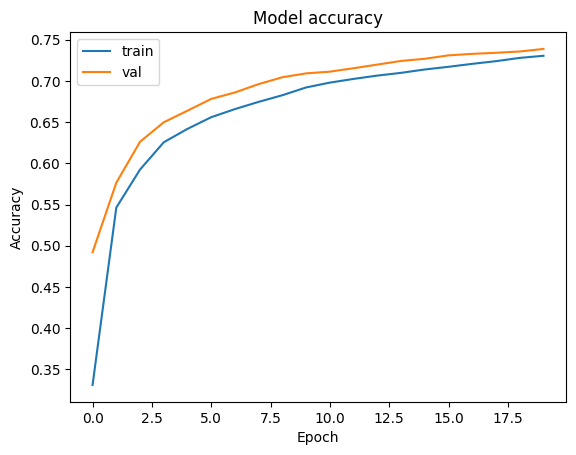

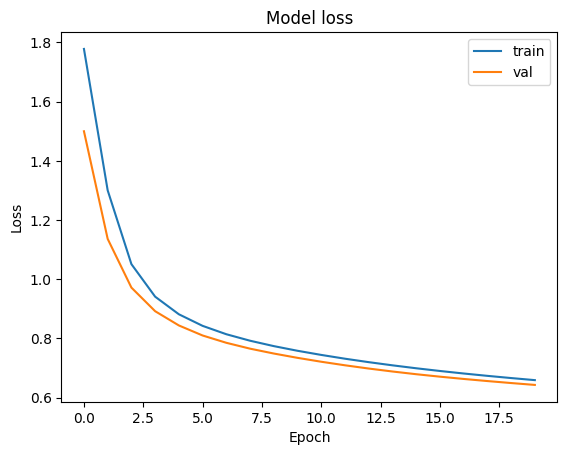

In [65]:
# Your code here


# Make results repeatable
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Get sizes (you already printed these before)
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

# 1) Build the model: input -> 64 -> 32 -> output
model = models.Sequential([
    layers.Input(shape=(num_features,)),    # 1D array with length = number of features
    layers.Dense(64, activation='relu'),    # hidden layer with 64 neurons
    layers.Dense(32, activation='relu'),    # hidden layer with 32 neurons
    layers.Dense(num_classes, activation='softmax')  # output probabilities for each class
])

# Show model layout
model.summary()

# 2) Compile the model (set optimizer, loss, metrics)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',   # use this when labels are integers like 0,1,2...
    metrics=['accuracy']
)

# 3) Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

print(history.history['accuracy'])

final_acc = history.history['accuracy'][-1]   # -1 = last item in the list
print("Final training accuracy:", final_acc)

# 4) Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, batch_size=32, verbose=1)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# 5) Plot training curves (accuracy and loss)
def plot_history(history):
    # Accuracy plot
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.show()

plot_history(history)


In [66]:
# Set a1a to the final training accuracy at epoch 20

a1a = final_acc             # Replace 0.0 with your answer

In [67]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.7304


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


======== Training with batch_size = 4 ========
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.3975 - loss: 1.6356 - val_accuracy: 0.6188 - val_loss: 0.9743
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6248 - loss: 0.9384 - val_accuracy: 0.6713 - val_loss: 0.8259
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6633 - loss: 0.8265 - val_accuracy: 0.6927 - val_loss: 0.7666
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6853 - loss: 0.7733 - val_accuracy: 0.7038 - val_loss: 0.7277
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7014 - loss: 0.7358 - val_accuracy: 0.7184 - val_loss: 0.6982
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7131 - loss: 0.7066 - val_accuracy: 0.7249 - val_loss: 0.6750
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7224 - loss: 0.6833 - val_accuracy: 0.7306 - val_loss: 0.6561
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━

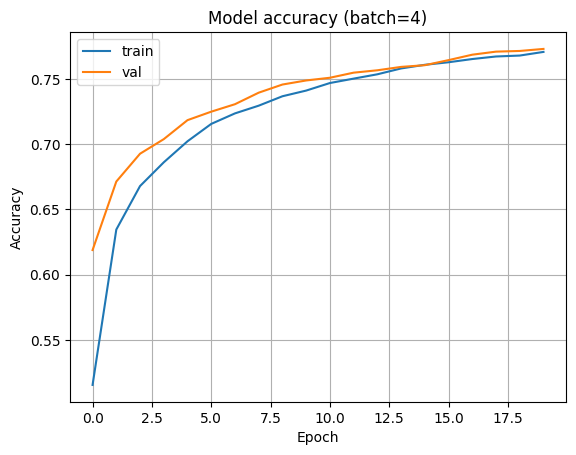

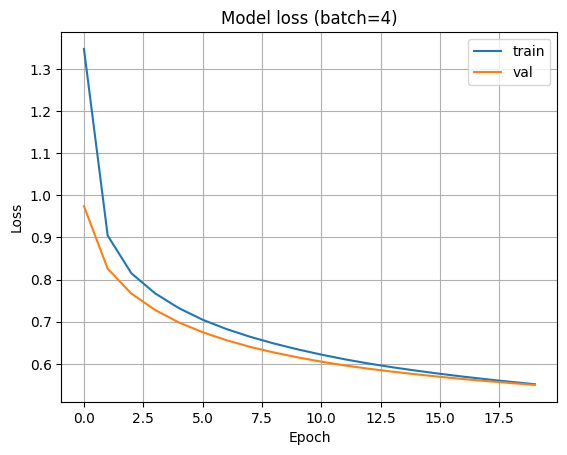


======== Training with batch_size = 8 ========
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3200 - loss: 1.7782 - val_accuracy: 0.5952 - val_loss: 1.0912
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6043 - loss: 1.0290 - val_accuracy: 0.6472 - val_loss: 0.8870
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6486 - loss: 0.8837 - val_accuracy: 0.6742 - val_loss: 0.8180
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6666 - loss: 0.8235 - val_accuracy: 0.6856 - val_loss: 0.7764
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6781 - loss: 0.7839 - val_accuracy: 0.6942 - val_loss: 0.7458
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6887 - loss: 0.7535 - val_accuracy: 0.7036 - val_loss: 0.7212
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7029 - loss: 0.7281 - val_accuracy: 0.7127 - val_loss: 0.7006
Epoch 8/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━

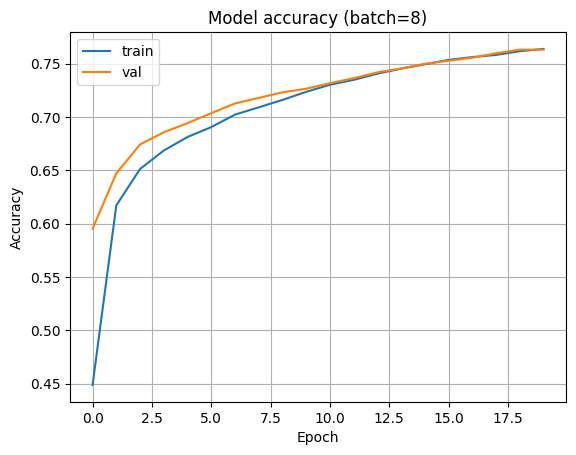

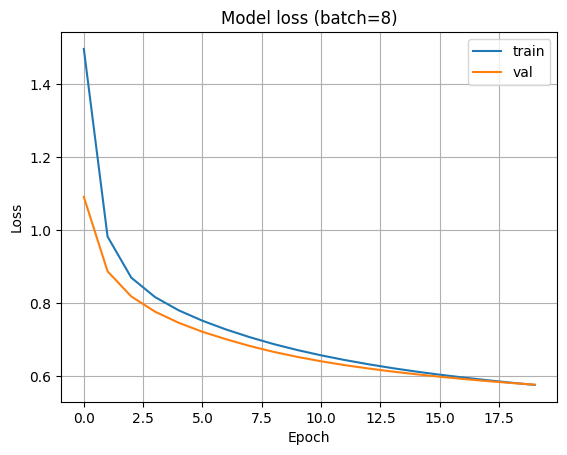


======== Training with batch_size = 16 ========
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2544 - loss: 1.9207 - val_accuracy: 0.5702 - val_loss: 1.2587
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5873 - loss: 1.1717 - val_accuracy: 0.6277 - val_loss: 0.9748
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6270 - loss: 0.9537 - val_accuracy: 0.6537 - val_loss: 0.8735
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6515 - loss: 0.8708 - val_accuracy: 0.6739 - val_loss: 0.8206
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6711 - loss: 0.8246 - val_accuracy: 0.6958 - val_loss: 0.7853
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6867 - loss: 0.7921 - val_accuracy: 0.7049 - val_loss: 0.7588
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6943 - loss: 0.7668 - val_accuracy: 0.7077 - val_loss: 0.7379
Epoch 8/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - a

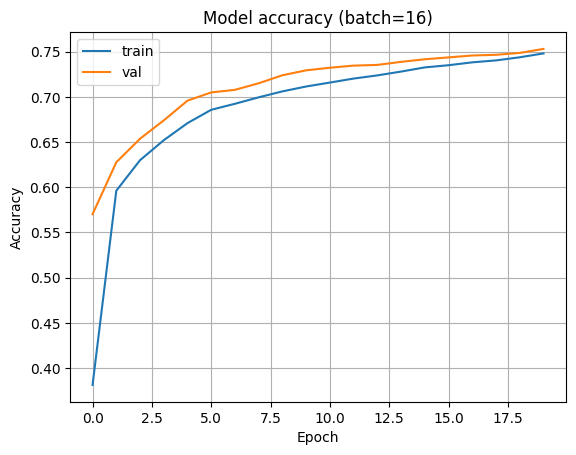

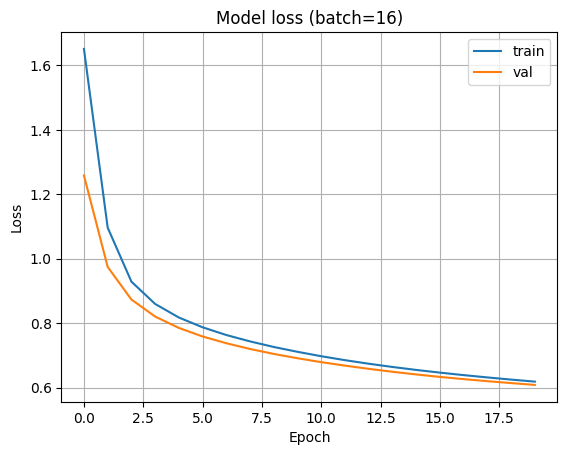


======== Training with batch_size = 128 ========
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2293 - loss: 1.9553 - val_accuracy: 0.3398 - val_loss: 1.7708
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3796 - loss: 1.7077 - val_accuracy: 0.4628 - val_loss: 1.5584
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4882 - loss: 1.5030 - val_accuracy: 0.5530 - val_loss: 1.3731
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5572 - loss: 1.3270 - val_accuracy: 0.5905 - val_loss: 1.2231
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5893 - loss: 1.1884 - val_accuracy: 0.6126 - val_loss: 1.1127
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6104 - loss: 1.0891 - val_accuracy: 0.6264 - val_loss: 1.0363
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6201 - loss: 1.0206 - val_accuracy: 0.6336 - val_loss: 0.9820
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

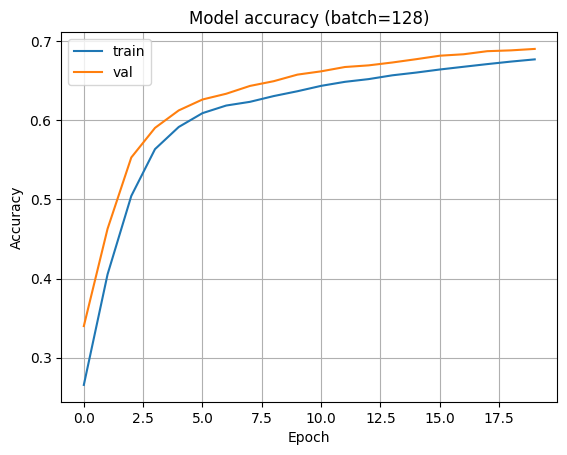

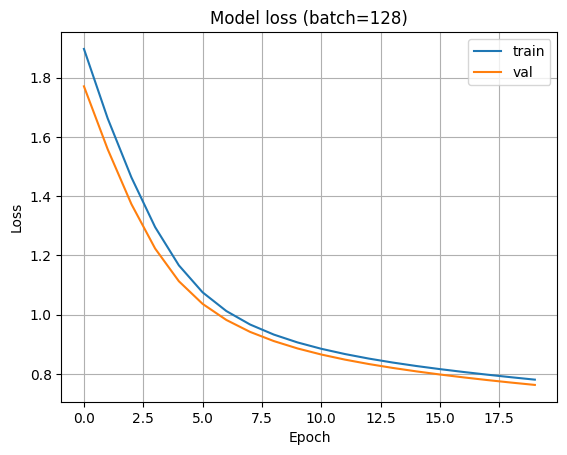


Summary of runs:
   batch_size  final_train_acc  final_val_acc  best_val_acc  epoch_best_val  \
0           4         0.770721       0.773011      0.773011              20   
1           8         0.763830       0.763131      0.763131              19   
2          16         0.748034       0.752990      0.752990              20   
3         128         0.677111       0.690328      0.690328              20   

   time_seconds  
0    189.303316  
1    117.221670  
2     59.971180  
3     14.347112  


In [89]:
# Your code here
# Problem Two: Batch Sizes -- run 4 experiments and plot results

import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import OrderedDict

# ---- repeatable randomness ----
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# ---- sizes (from your data) ----
num_features = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train))

# ---- model builder function (builds a fresh model each time) ----
def build_model():
    # re-seed before building to make initial weights comparable across runs
    tf.random.set_seed(random_seed)
    model = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---- plotting helper (draws accuracy and loss) ----
def plot_history(history, title=None):
    if title is None:
        title = ""
    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

# ---- experiment loop ----
batch_sizes = [4, 8, 16, 128]
results = []         # will hold summary rows
histories = {}       # store each history if you want to inspect later

for bs in batch_sizes:
    print("\n" + "="*8 + f" Training with batch_size = {bs} " + "="*8)
    model = build_model()   # fresh model
    start_time = time.time()
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,
        batch_size=bs,
        verbose=1
    )
    elapsed = time.time() - start_time

    histories[bs] = history

    # collect simple summary numbers
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    epoch_best_val = int(np.argmax(history.history['val_accuracy'])) + 1

    results.append({
        'batch_size': bs,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'best_val_acc': best_val_acc,
        'epoch_best_val': epoch_best_val,
        'time_seconds': elapsed
    })

    # plot curves for this run
    plot_history(history, title=f"(batch={bs})")

# ---- show comparison table ----
summary_df = pd.DataFrame(results).sort_values('batch_size')
print("\nSummary of runs:")
print(summary_df)



# optionally save summary to a file for submission
summary_df.to_csv('batch_size_summary.tsv', sep='\t', index=False)


In [90]:
summary_df = pd.DataFrame(results)   # results is the list created in the experiment loop
# find the row with the largest final validation accuracy (at epoch 20)
best_row = summary_df.loc[summary_df['final_val_acc'].idxmax()]

In [91]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = int(best_row['batch_size'])             # Replace 0 with your answer

In [92]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')

a2a = 4


In [93]:
# Set a2b to the best accuracy score found

a2b = float(best_row['final_val_acc'])             # Replace 0.0 with your answer

In [94]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7730


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



======== Training with lr = 0.001 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5023 - loss: 1.3152 - val_accuracy: 0.6984 - val_loss: 0.7522
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6958 - loss: 0.7448 - val_accuracy: 0.7343 - val_loss: 0.6623
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7265 - loss: 0.6673 - val_accuracy: 0.7454 - val_loss: 0.6179
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7453 - loss: 0.6230 - val_accuracy: 0.7579 - val_loss: 0.5872
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7563 - loss: 0.5921 - val_accuracy: 0.7663 - val_loss: 0.5675
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7639 - loss: 0.5684 - val_accuracy: 0.7733 - val_loss: 0.5521
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7721 - loss: 0.5491 - val_accuracy: 0.7806 - val_loss: 0.5380
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accura

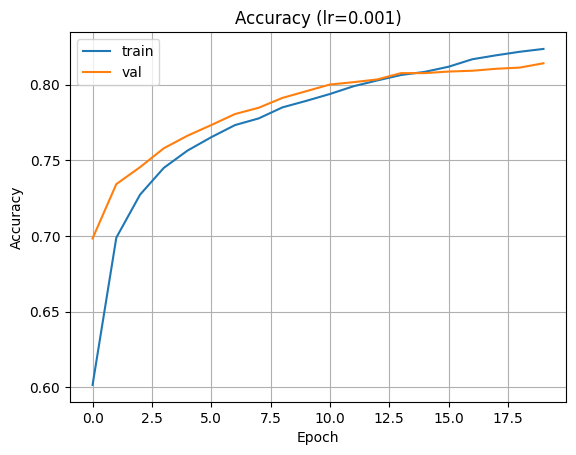

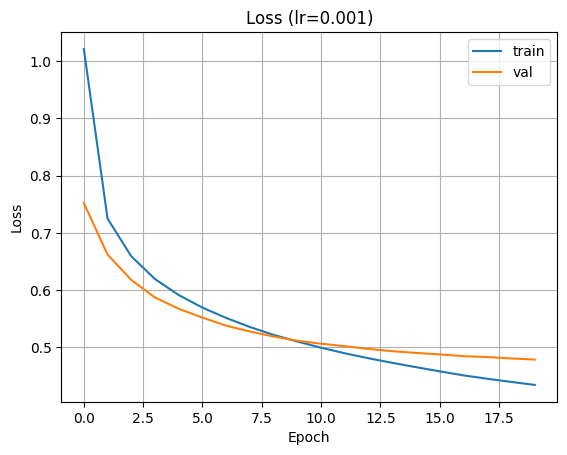


======== Training with lr = 0.0005 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4061 - loss: 1.5566 - val_accuracy: 0.6661 - val_loss: 0.8546
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6668 - loss: 0.8263 - val_accuracy: 0.7067 - val_loss: 0.7298
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7044 - loss: 0.7308 - val_accuracy: 0.7304 - val_loss: 0.6791
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7189 - loss: 0.6848 - val_accuracy: 0.7363 - val_loss: 0.6486
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7323 - loss: 0.6550 - val_accuracy: 0.7418 - val_loss: 0.6273
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7434 - loss: 0.6320 - val_accuracy: 0.7499 - val_loss: 0.6107
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7516 - loss: 0.6128 - val_accuracy: 0.7551 - val_loss: 0.5967
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accur

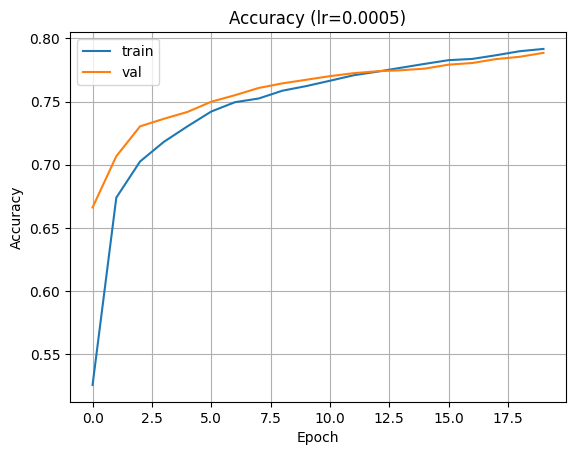

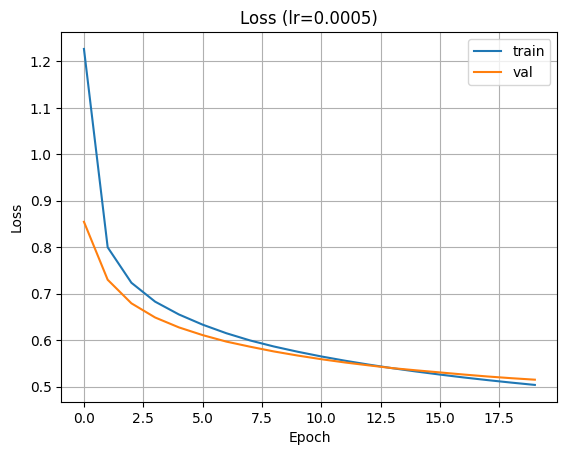


======== Training with lr = 0.0001 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2777 - loss: 1.8338 - val_accuracy: 0.5390 - val_loss: 1.3796
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5565 - loss: 1.2907 - val_accuracy: 0.6050 - val_loss: 1.0697
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6085 - loss: 1.0365 - val_accuracy: 0.6414 - val_loss: 0.9393
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6368 - loss: 0.9281 - val_accuracy: 0.6599 - val_loss: 0.8740
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6538 - loss: 0.8726 - val_accuracy: 0.6737 - val_loss: 0.8334
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6666 - loss: 0.8369 - val_accuracy: 0.6849 - val_loss: 0.8048
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6754 - loss: 0.8103 - val_accuracy: 0.6924 - val_loss: 0.7828
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accur

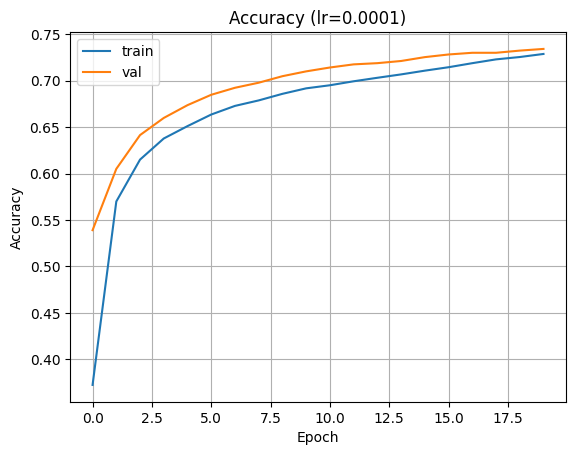

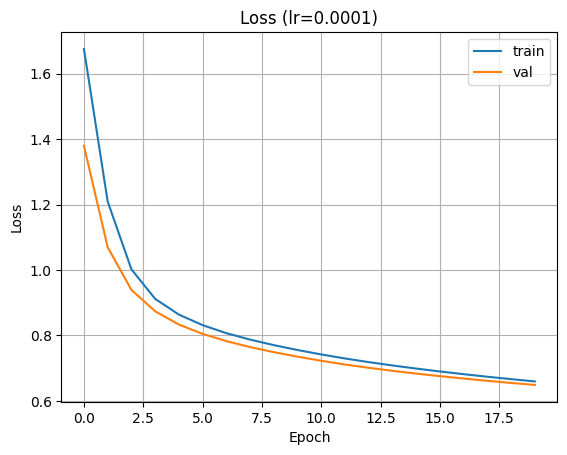


======== Training with lr = 5e-05 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2649 - loss: 1.9302 - val_accuracy: 0.3913 - val_loss: 1.6795
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4178 - loss: 1.6112 - val_accuracy: 0.5075 - val_loss: 1.4319
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5282 - loss: 1.3786 - val_accuracy: 0.5874 - val_loss: 1.2463
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5833 - loss: 1.2070 - val_accuracy: 0.6095 - val_loss: 1.1132
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6007 - loss: 1.0869 - val_accuracy: 0.6256 - val_loss: 1.0239
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6199 - loss: 1.0077 - val_accuracy: 0.6399 - val_loss: 0.9628
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6307 - loss: 0.9529 - val_accuracy: 0.6503 - val_loss: 0.9194
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accura

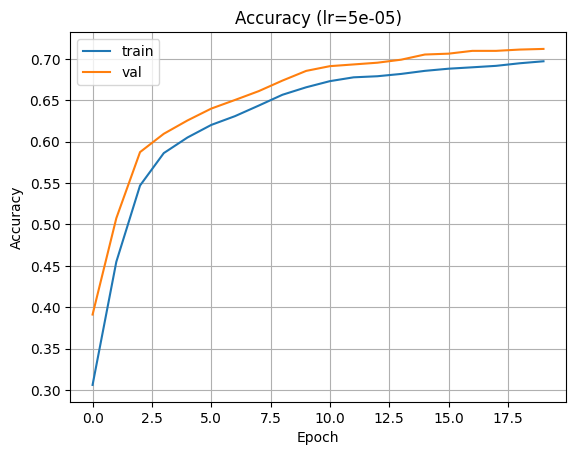

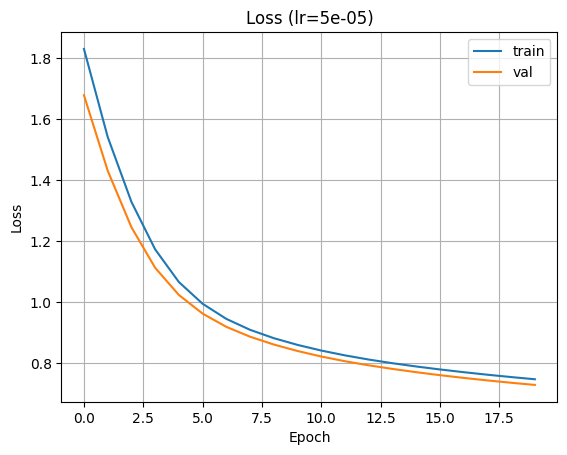


======== Training with lr = 1e-05 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1604 - loss: 2.0448 - val_accuracy: 0.1789 - val_loss: 2.0011
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1941 - loss: 1.9555 - val_accuracy: 0.2231 - val_loss: 1.9198
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2459 - loss: 1.8771 - val_accuracy: 0.2795 - val_loss: 1.8467
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3057 - loss: 1.8063 - val_accuracy: 0.3315 - val_loss: 1.7797
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3561 - loss: 1.7409 - val_accuracy: 0.3729 - val_loss: 1.7170
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3962 - loss: 1.6797 - val_accuracy: 0.4048 - val_loss: 1.6579
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4226 - loss: 1.6218 - val_accuracy: 0.4285 - val_loss: 1.6015
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accura

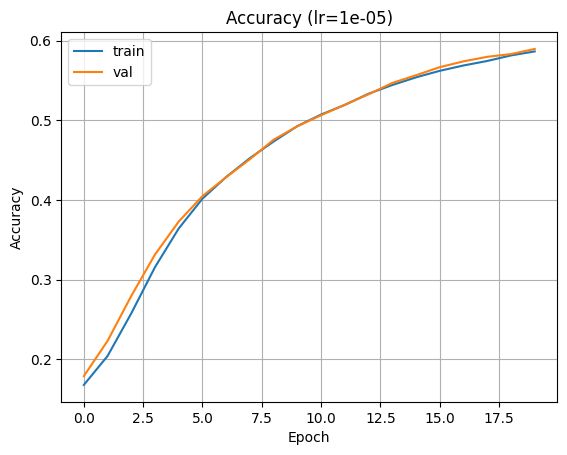

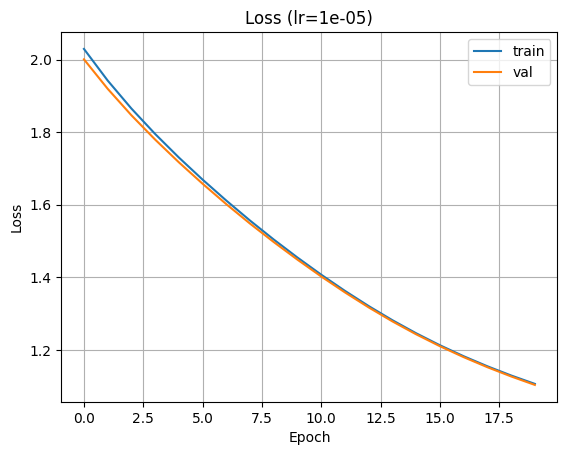


Summary of learning-rate runs:
   learning_rate  final_train_acc  final_val_acc  best_val_acc  \
0        0.00100         0.823572       0.814093      0.814093   
1        0.00050         0.791718       0.788612      0.788612   
2        0.00010         0.728857       0.734269      0.734269   
3        0.00005         0.697003       0.711908      0.711908   
4        0.00001         0.586297       0.589444      0.589444   

   epoch_best_val  time_seconds  
0              20     28.131054  
1              20     29.927028  
2              20     29.386346  
3              20     32.631139  
4              20     31.239851  


In [106]:
# Your code here
# Model builder that accepts a learning rate
def build_model(lr):
    # clear previous models and set seed so starts are comparable
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)
    model = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Simple plotting helper (train vs val)
def plot_history(history, title=None):
    if title is None:
        title = ""
    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Accuracy {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

# Learning rates to test
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results = []
histories = {}

for lr in learning_rates:
    print("\n" + "="*8 + f" Training with lr = {lr} " + "="*8)
    model = build_model(lr)
    start_time = time.time()
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,
        batch_size=32,
        verbose=1
    )
    elapsed = time.time() - start_time

    histories[lr] = history

    final_train_acc = history.history['accuracy'][-1]    # training acc at epoch 20
    final_val_acc = history.history['val_accuracy'][-1]  # validation acc at epoch 20
    best_val_acc = max(history.history['val_accuracy'])  # best val acc during training
    epoch_best_val = int(np.argmax(history.history['val_accuracy'])) + 1

    results.append({
        'learning_rate': lr,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'best_val_acc': best_val_acc,
        'epoch_best_val': epoch_best_val,
        'time_seconds': elapsed
    })

    # show plots for this learning rate
    plot_history(history, title=f"(lr={lr})")

# Summary table
learning_rates_summary_df = pd.DataFrame(results).sort_values('learning_rate', ascending=False)
print("\nSummary of learning-rate runs:")
print(learning_rates_summary_df)

# Choose best by final validation accuracy at epoch 20
best_row = learning_rates_summary_df.loc[learning_rates_summary_df['final_val_acc'].idxmax()]


In [111]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = float(best_row['learning_rate'])              # Replace 0.0 with your answer

In [112]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.0010


In [113]:
# Set a3b to the accuracy found by the best learning rate

a3b = float(best_row['final_val_acc'])             # Replace 0.0 with your answer

In [114]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8141


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam.

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


======== Training with initial lr = 0.01 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5992 - loss: 0.9989 - val_accuracy: 0.7075 - val_loss: 0.6691
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7132 - loss: 0.6769 - val_accuracy: 0.7402 - val_loss: 0.6135
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7395 - loss: 0.6160 - val_accuracy: 0.7491 - val_loss: 0.6021
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7525 - loss: 0.5816 - val_accuracy: 0.7741 - val_loss: 0.5563
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7662 - loss: 0.5497 - val_accuracy: 0.7683 - val_loss: 0.5533
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7735 - loss: 0.5402 - val_accuracy: 0.7847 - val_loss: 0.5263
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7843 - loss: 0.5044 - val_accuracy: 0.7756 - val_loss: 0.5341
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

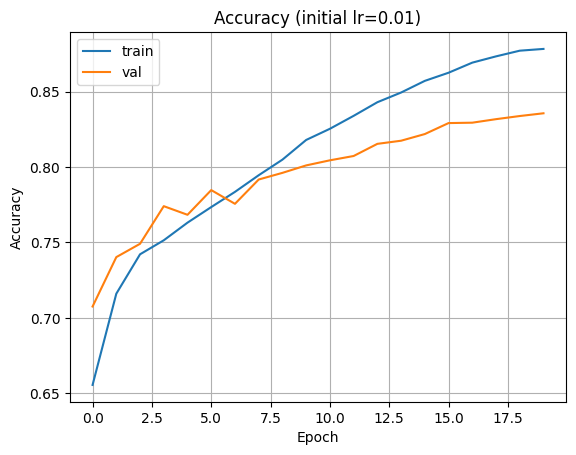

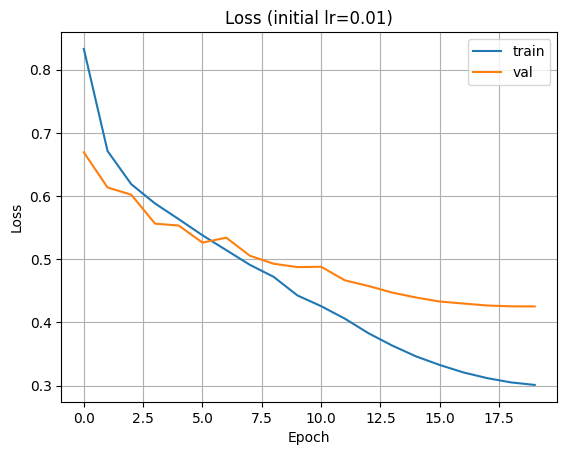


======== Training with initial lr = 0.005 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5971 - loss: 1.0118 - val_accuracy: 0.7220 - val_loss: 0.6581
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7224 - loss: 0.6597 - val_accuracy: 0.7540 - val_loss: 0.5975
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7534 - loss: 0.5979 - val_accuracy: 0.7699 - val_loss: 0.5616
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7719 - loss: 0.5622 - val_accuracy: 0.7842 - val_loss: 0.5313
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7843 - loss: 0.5298 - val_accuracy: 0.7928 - val_loss: 0.5238
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7960 - loss: 0.4970 - val_accuracy: 0.7933 - val_loss: 0.5145
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8030 - loss: 0.4735 - val_accuracy: 0.8001 - val_loss: 0.4962
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

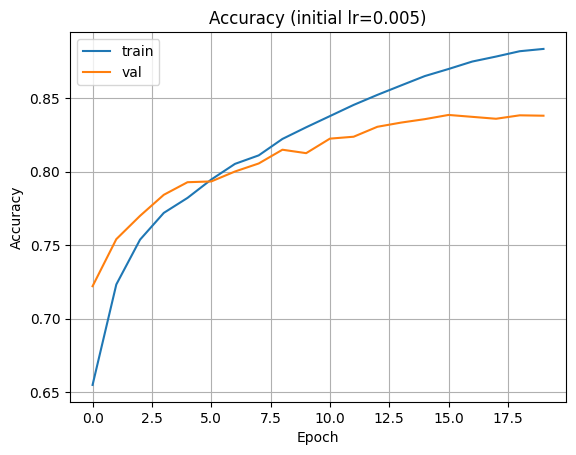

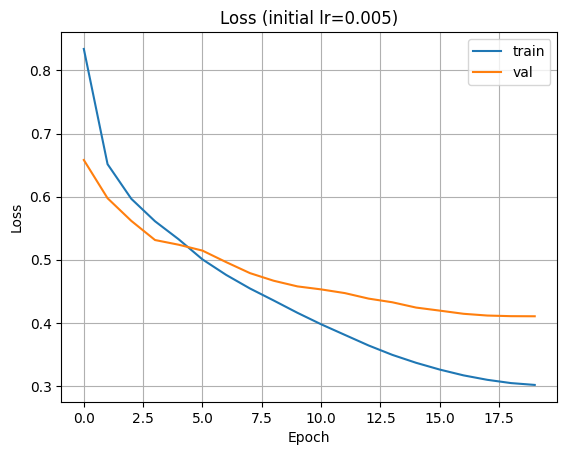


======== Training with initial lr = 0.001 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5063 - loss: 1.3323 - val_accuracy: 0.6992 - val_loss: 0.7607
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6937 - loss: 0.7543 - val_accuracy: 0.7337 - val_loss: 0.6705
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7226 - loss: 0.6725 - val_accuracy: 0.7475 - val_loss: 0.6256
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7382 - loss: 0.6245 - val_accuracy: 0.7577 - val_loss: 0.5969
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7523 - loss: 0.5918 - val_accuracy: 0.7678 - val_loss: 0.5755
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7647 - loss: 0.5664 - val_accuracy: 0.7725 - val_loss: 0.5600
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7737 - loss: 0.5467 - val_accuracy: 0.7806 - val_loss: 0.5478
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

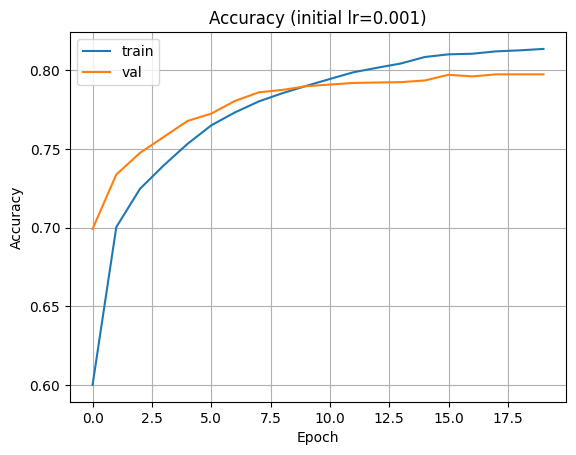

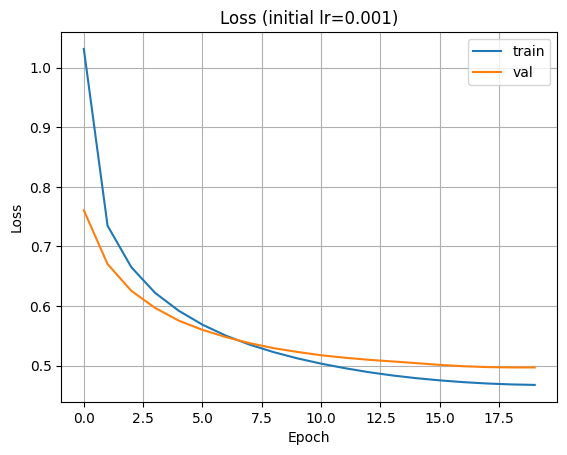


======== Training with initial lr = 0.0005 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4083 - loss: 1.5586 - val_accuracy: 0.6581 - val_loss: 0.8497
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6569 - loss: 0.8305 - val_accuracy: 0.6893 - val_loss: 0.7473
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6942 - loss: 0.7483 - val_accuracy: 0.7101 - val_loss: 0.6968
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7167 - loss: 0.7001 - val_accuracy: 0.7257 - val_loss: 0.6633
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7316 - loss: 0.6661 - val_accuracy: 0.7343 - val_loss: 0.6405
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7411 - loss: 0.6409 - val_accuracy: 0.7423 - val_loss: 0.6239
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7472 - loss: 0.6209 - val_accuracy: 0.7486 - val_loss: 0.6104
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

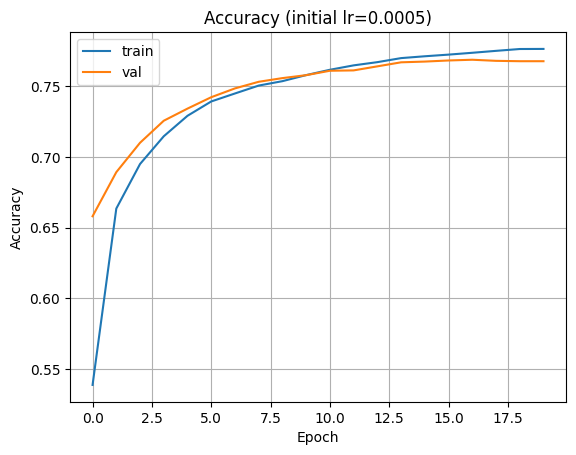

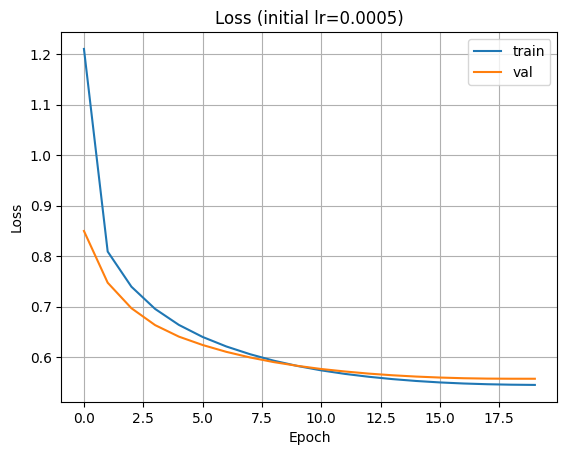


======== Training with initial lr = 0.0001 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2224 - loss: 1.9047 - val_accuracy: 0.4995 - val_loss: 1.4495
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5216 - loss: 1.3613 - val_accuracy: 0.5681 - val_loss: 1.1508
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5682 - loss: 1.1156 - val_accuracy: 0.6131 - val_loss: 1.0163
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6106 - loss: 0.9985 - val_accuracy: 0.6459 - val_loss: 0.9378
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6380 - loss: 0.9300 - val_accuracy: 0.6586 - val_loss: 0.8888
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6497 - loss: 0.8870 - val_accuracy: 0.6648 - val_loss: 0.8571
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6598 - loss: 0.8582 - val_accuracy: 0.6745 - val_loss: 0.8342
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

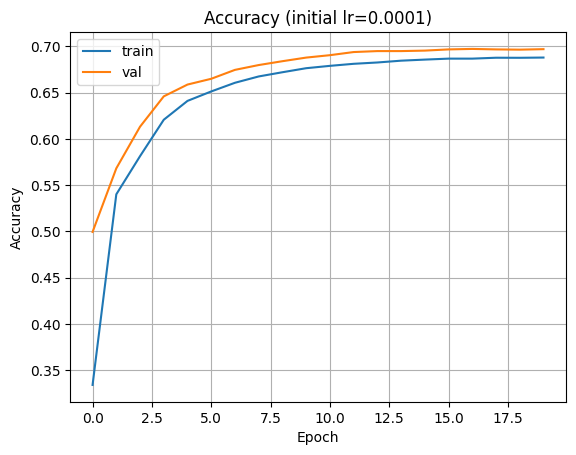

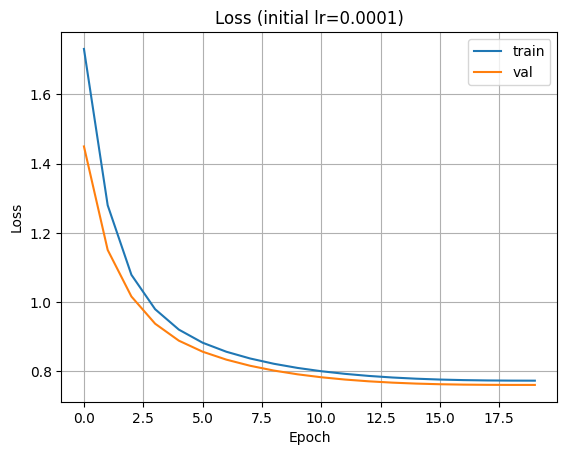


Summary of Cosine Decay runs:
   initial_lr  final_val_acc
0      0.0100       0.835673
1      0.0050       0.838014
2      0.0010       0.797452
3      0.0005       0.767811
4      0.0001       0.696828


In [115]:
# Your code here
from tensorflow.keras.optimizers.schedules import CosineDecay
# ---- model builder with Cosine Decay ----
def build_model_with_cosine(lr_init, batch_size, epochs):
    tf.keras.backend.clear_session()        # clear old models
    tf.random.set_seed(random_seed)

    steps_per_epoch = int(np.ceil(len(X_train_scaled) / batch_size))
    total_steps = epochs * steps_per_epoch

    # define Cosine Decay schedule
    lr_schedule = CosineDecay(
        initial_learning_rate=lr_init,
        decay_steps=total_steps,
        alpha=0.0   # final learning rate goes to 0
    )

    # build model
    model = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # compile with Adam using schedule
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---- plotting helper ----
def plot_history(history, title=None):
    if title is None:
        title = ""
    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Accuracy {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

# ---- experiments ----
initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
batch_size = 32
epochs = 20

results = []
histories = {}

for lr in initial_lrs:
    print("\n" + "="*8 + f" Training with initial lr = {lr} " + "="*8)
    model = build_model_with_cosine(lr, batch_size, epochs)

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    histories[lr] = history

    final_val_acc = history.history['val_accuracy'][-1]
    results.append({
        'initial_lr': lr,
        'final_val_acc': final_val_acc
    })

    plot_history(history, title=f"(initial lr={lr})")

# ---- summary ----
import pandas as pd
cosine_summary = pd.DataFrame(results).sort_values('initial_lr', ascending=False)
print("\nSummary of Cosine Decay runs:")
print(cosine_summary)

# ---- best learning rate & accuracy ----
best_row = cosine_summary.loc[cosine_summary['final_val_acc'].idxmax()]


In [116]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = float(best_row['initial_lr'])             # Replace 0.0 with your answer

In [117]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.4f}')

a4a = 0.0050


In [118]:
# Set a4b to the best accuracy found

a4b = float(best_row['final_val_acc'])              # Replace 0.0 with your answer

In [119]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8380


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture.

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.

In [120]:


# --- standardize each table to the same column names ---
def standarize_batch(df):
    d = df.copy()
    d['kind'] = 'batch'
    d['use_cosine'] = False
    d['initial_lr'] = np.nan
    # ensure batch_size exists
    if 'batch_size' not in d.columns:
        d['batch_size'] = 32
    return d

def standarize_const_lr(df):
    d = df.copy()
    d['kind'] = 'const_lr'
    d['use_cosine'] = False
    # unify learning rate column name to 'initial_lr'
    if 'learning_rate' in d.columns:
        d['initial_lr'] = d['learning_rate']
    elif 'initial_lr' not in d.columns:
        d['initial_lr'] = np.nan
    if 'batch_size' not in d.columns:
        d['batch_size'] = 32
    return d

def standarize_cosine(df):
    d = df.copy()
    d['kind'] = 'cosine'
    d['use_cosine'] = True
    if 'initial_lr' not in d.columns and 'learning_rate' in d.columns:
        d['initial_lr'] = d['learning_rate']
    if 'batch_size' not in d.columns:
        d['batch_size'] = 32
    return d

b = standarize_batch(summary_df)
c = standarize_const_lr(learning_rates_summary_df)
s = standarize_cosine(cosine_summary)

all_df = pd.concat([b, c, s], ignore_index=True, sort=False)

# Ensure we have required columns
# 'final_val_acc', 'best_val_acc', 'epoch_best_val', 'time_seconds' are helpful

# Primary selection: best final_val_acc at epoch 20
best_val = all_df['final_val_acc'].max()
candidates = all_df[all_df['final_val_acc'] == best_val]

# Tie-breaker sort: prefer higher best_val_acc, earlier epoch_best_val, shorter time
candidates = candidates.sort_values(
    by=['best_val_acc', 'epoch_best_val', 'time_seconds'],
    ascending=[False, True, True]
)

best_row = candidates.iloc[0]

# Map to final hyperparameters
batch_size = int(best_row['batch_size'])
epochs = 20
use_cosine_schedule = bool(best_row['use_cosine'])
# initial_lr could be NaN for batch-only table; handle that
initial_lr = float(best_row['initial_lr']) if not pd.isna(best_row['initial_lr']) else None

print("Chosen hyperparameters:")
print(" batch_size =", batch_size)
print(" epochs =", epochs)
print(" use_cosine_schedule =", use_cosine_schedule)
print(" initial_lr =", initial_lr)


Chosen hyperparameters:
 batch_size = 32
 epochs = 20
 use_cosine_schedule = False
 initial_lr = None


In [83]:
# Your code here -- add as many cells as you need

import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
import matplotlib.pyplot as plt

# reproducible
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Use the values you chose above
batch_size = best_batch_size
epochs = 20
initial_lr = best_initial_lr
use_cosine_schedule = use_cosine  # True/False

# number of features/classes (from your data)
num_features = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train))

# Build the same model architecture (do NOT change architecture)
def build_model_with_optimizer(optimizer):
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)
    m = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

# Create optimizer: either CosineDecay schedule or fixed lr
if use_cosine_schedule:
    steps_per_epoch = int(np.ceil(len(X_train_scaled) / batch_size))
    total_steps = epochs * steps_per_epoch
    lr_schedule = CosineDecay(initial_learning_rate=initial_lr,
                              decay_steps=total_steps,
                              alpha=0.0)
    optimizer = Adam(learning_rate=lr_schedule)
else:
    optimizer = Adam(learning_rate=initial_lr)

# Build model with chosen optimizer
best_model = build_model_with_optimizer(optimizer)

# Decide training data to use for final fit:
# Preferred: if you have a separate validation set (X_val_scaled, y_val), combine train+val
try:
    # If X_val_scaled exists in your session, use full training = train + val
    X_full = np.vstack([X_train_scaled, X_val_scaled])
    y_full = np.concatenate([y_train, y_val])
    print("Using train+val combined for final training (preferred).")
except NameError:
    # Otherwise fall back to using just the training set
    X_full = X_train_scaled
    y_full = y_train
    print("No separate validation set found — using original training set for final training.")

# Train the final model and keep history so we can plot
history_final = best_model.fit(
    X_full, y_full,
    validation_data=(X_test_scaled, y_test),   # test set used only for evaluation/monitoring here
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Evaluate on the test set (final score to report)
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Final test loss: {test_loss:.4f}, Final test accuracy: {test_accuracy:.4f}")

# Plot helper (same as before)
def plot_history(history, title=None):
    if title is None:
        title = ""
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

plot_history(history_final, title="(final chosen model)")


In [84]:
# Set a5a to the best training accuracy found by your best model

a5a = 0.0             # Replace 0.0 with your answer

In [85]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.4f}')

a5a = 0.0000


In [86]:
# Set a5b to the test accuracy found by your best model

a5b = 0.0             # Replace 0.0 with your answer

In [87]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.0000


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc?

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


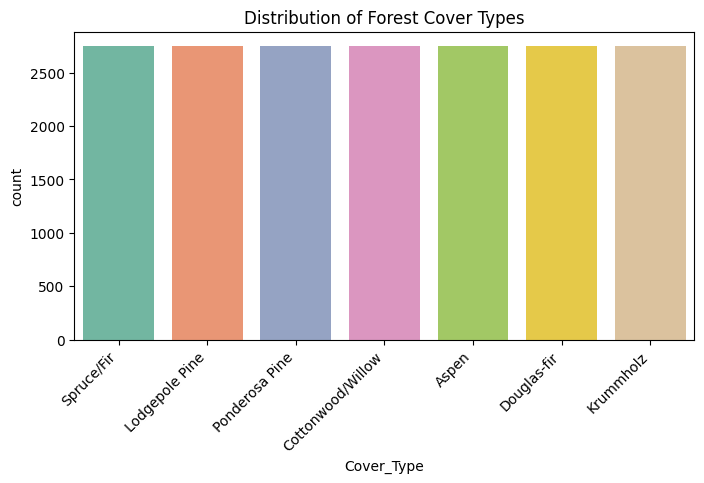

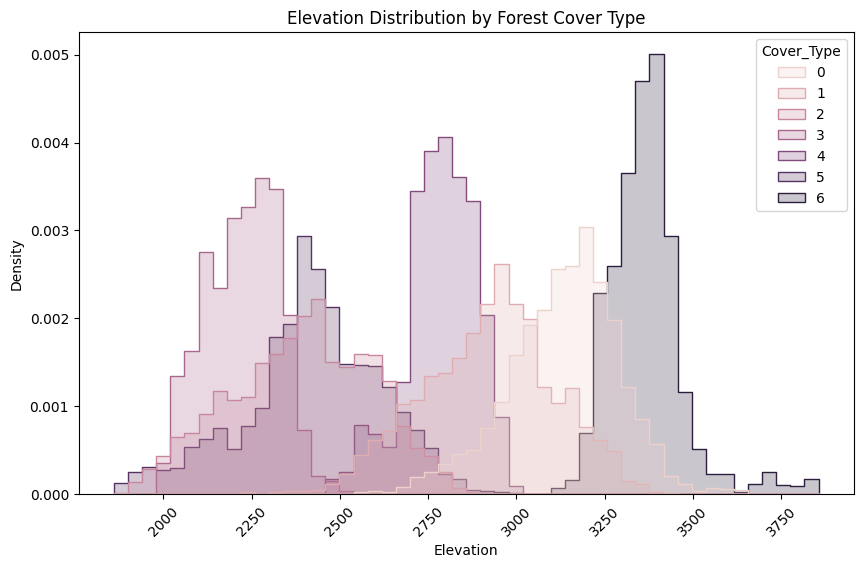

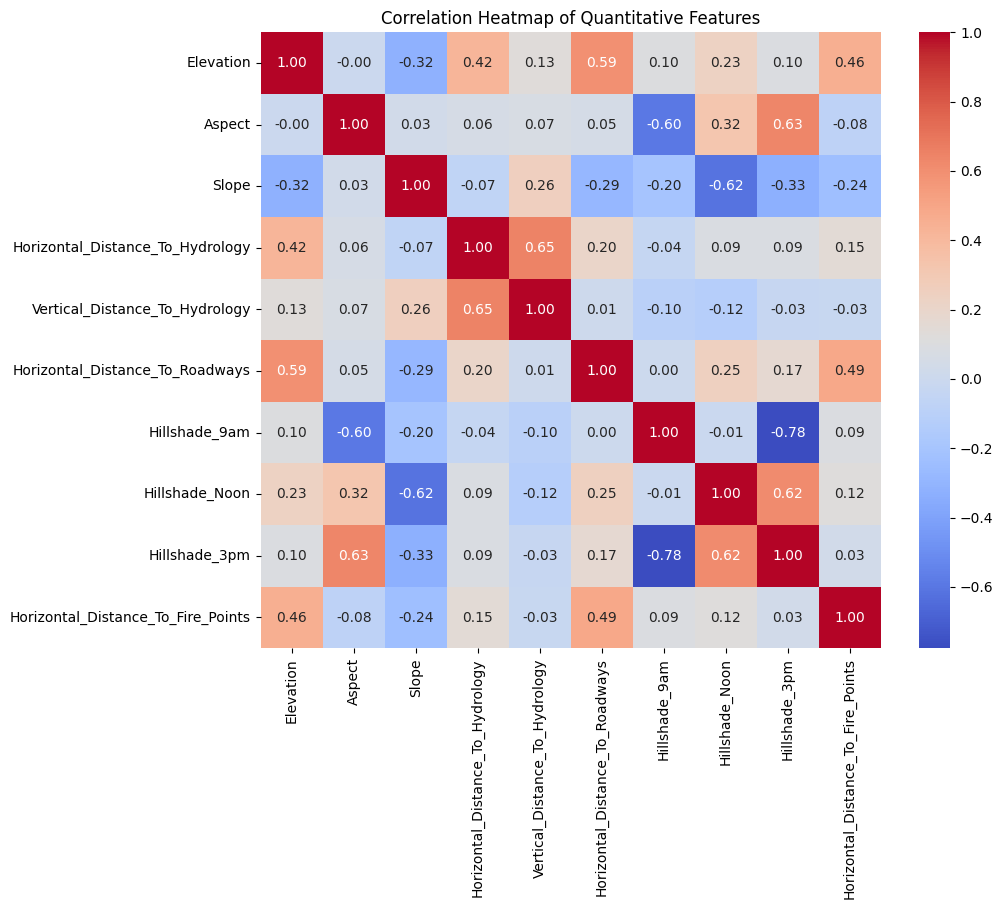

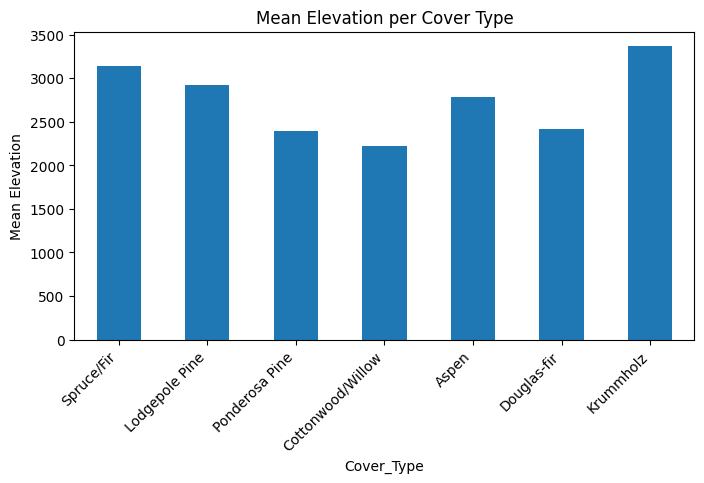

In [88]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
